In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

In [24]:
col_names=['ch1','ch2','ch3','ch4']
gesture_names = ['Rest','Extension','Flexion','UlnarDeviation','RadialDeviation','Grip','AbductionOfFingers','AdductionOfFingers','Supination','Pronation']

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

standardscaler = StandardScaler() # sets values have mean to 0 with standard deviation
minmaxscaler = MinMaxScaler() # sets minimum signal to 0, maximum signal to 1, and other values between them

In [26]:
def minimum(raw, box_size, mode='nearest'): # Maximum Filter
    raw_minimum=ndimage.minimum_filter(raw,box_size,mode=mode)
    return raw_minimum.real

def median(raw, box_size, mode='nearest'): # Median Filter
    raw_median=ndimage.median_filter(raw,box_size,mode=mode)
    return raw_median.real

def maximum(raw, box_size, mode='nearest'): # Maximum Filter
    raw_maximum=ndimage.maximum_filter(raw,box_size,mode=mode)
    return raw_maximum.real

def denoise_fft(data, ifftn): # Fast Fourier Transformation
    fft_signal = np.fft.fft(data)
    
    # Reconstruct the original signal
    fft_signal[ifftn:len(fft_signal)//2]=0
    fft_signal[len(fft_signal)//2:-ifftn]=0
    reconstructed_signal = np.fft.ifft(fft_signal)
    
    return reconstructed_signal.real

def smooth(x,beta): # Kaiser Window Smoothing
    window_len=11  # extending the data at beginning and at the end to apply the window at the borders

    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

In [46]:
import warnings
warnings.filterwarnings('ignore') # too many warnings (use DataFrame.transpose instead of DataFrame.swapaxes)
c=0
for i in range(40): # data1 to data40
    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)

    globals()['data{}_patterns'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time

    for j in range(5): # pattern1 to pattern5
        globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_patterns'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures
        
        for g in range(10): # gesture1 to gesture10
            #if j==0: # make arrays in person with gesture names
            globals()['data{}_{}_{}_signal'.format(i+1,gesture_names[g],j+1)] = globals()['data{}_gestures{}'.format(i+1,j+1)][g].reset_index(drop=True).to_numpy()[2000:18000,:] 
               
            #else: # horizontally concat later gesture arrays to the previously generated array
                #globals()['data{}_{}_signal'.format(i+1,gesture_names[g])] = np.concatenate((globals()['data{}_{}_signal'.format(i+1,gesture_names[g])],globals()['data{}_gestures{}'.format(i+1,j+1)][g].reset_index(drop=True).to_numpy()[2000:6000,:]),axis=0)

        c+=1
        #print('i:{} j:{} c:{}'.format(i+1,j+1,c))

In [47]:
data1_Rest_1_signal[:,2]

array([7.18383789, 7.17102051, 7.16705322, ..., 7.15515137, 7.14752197,
       7.14141846])

In [28]:
for i in range(40):
    for g in gesture_names:
        globals()['data{}_{}_signal_standard'.format(i+1,g)] = np.ndarray(globals()['data{}_{}_signal'.format(i+1,g)].shape)
        globals()['data{}_{}_signal_standard'.format(i+1,g)] = standardscaler.fit_transform(globals()['data{}_{}_signal'.format(i+1,g)])

In [51]:
for i in range(40): # 196(?) samples
    for g in gesture_names: # 10 gestures
        for j in range(5):
            globals()['data{}_{}_{}_filtered'.format(i+1,g,j+1)] = np.ndarray(globals()['data{}_{}_{}_signal'.format(i+1,g,j+1)].shape)
            for ch in range(4):
                globals()['data{}_{}_{}_filtered'.format(i+1,g,j+1)][:,ch] = smooth(denoise_fft(maximum(globals()['data{}_{}_{}_signal'.format(i+1,g,j+1)][:,ch],25)-minimum(globals()['data{}_{}_{}_signal'.format(i+1,g,j+1)][:,ch],20),10),5) # apply the filters

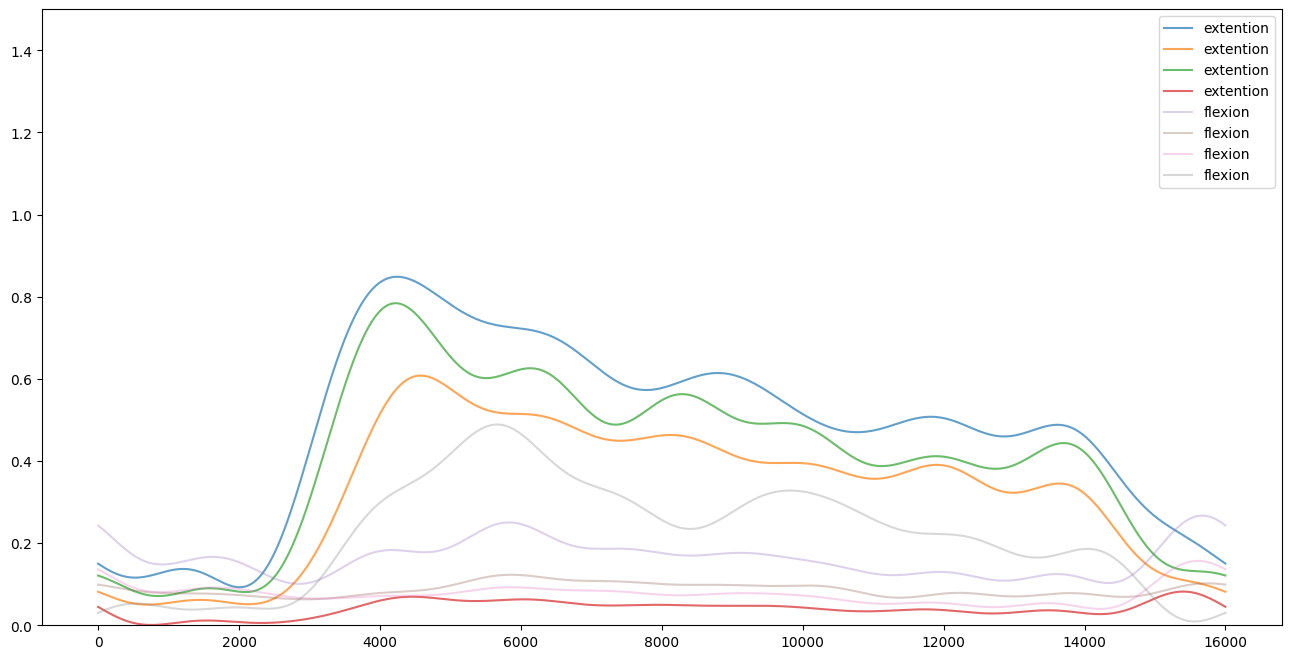

In [68]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.plot(data4_Extension_1_filtered,label='extention',alpha=0.7)
ax.plot(data4_Flexion_1_filtered,label='flexion',alpha=0.3)

ax.set_ylim([0,1.5])
plt.legend()
plt.show()